In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import sys
from os.path import abspath
sys.path.insert(0, abspath('..'))

from os.path import join

from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from spherecluster import SphericalKMeans, VonMisesFisherMixture

import numpy as np
from tabulate import tabulate

import logging

import torch


from torchSTC.data import load_data
from torchSTC.modules import STC
from torchSTC.metrics import SpacePlot, Evaluate
from torchSTC.utils.cluster import SphericalKmeans, SphericalKmeansPlus

plot = SpacePlot()
eval = Evaluate()

[nltk_data] Downloading package punkt to /home/godwin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /home/godwin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


>>>>> /home/godwin/Documents/academic/PPD/torchSTC/demos/SearchSnippets/wdecay
>>>>> data_loader.py cwd:  /home/godwin/Documents/academic/PPD/torchSTC/demos/SearchSnippets/wdecay


/home/godwin/Documents/academic/PPD/torchSTC/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

In [3]:
cur = abspath("")
dataset = 'SearchSnippets'
data_in_dir=join(cur, "../../..", "datasets")
dataset_dir=join(data_in_dir, dataset)

# Word2Vec

In [4]:
checkpoint_dir=join(dataset_dir, 
                    "artefacts",
                    "STC-d48:500:2000:20-epoch15-datSearchSnippets-wdeWord2Vec-scaMinMax-tfeSIF-normNone-initKmeans")

checkpoint = "STC-datSearchSnippets-wdeWord2Vec-scaMinMax-tfeSIF-normNone-initKmeans.pth"
checkpoint_path = join(checkpoint_dir, checkpoint)
checkpoint_path

'/home/godwin/Documents/academic/PPD/torchSTC/demos/SearchSnippets/wdecay/../../../datasets/SearchSnippets/artefacts/STC-d48:500:2000:20-epoch15-datSearchSnippets-wdeWord2Vec-scaMinMax-tfeSIF-normNone-initKmeans/STC-datSearchSnippets-wdeWord2Vec-scaMinMax-tfeSIF-normNone-initKmeans.pth'

In [5]:
x, y = load_data(dataset=dataset_dir, word_emb='Word2Vec', transform='SIF', scaler='MinMax', norm=None)
n_clusters = len(torch.unique(torch.tensor(y)))

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)

# conversion des données en tenseurs
X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

stc = STC(hidden_dims=[torch.Tensor(X_train).shape[-1], 500, 2000, 20], n_clusters=n_clusters)
stc.from_pretrained(checkpoint_path)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

### Embedding started...
Word2Vec words embedding loaded...
#### SIF embedding started...
SIF-Embedding 12339 documents with 48-dimensional word vectors...
SVD decomposition...
### SIF embedding completed...
### Embedding completed...
[embed_docs] XX shape:  (12340, 48)
>>> |  (12340, 48)
MinMax scaling completed...
No normalization applied...


(torch.Size([11106, 48]),
 torch.Size([1234, 48]),
 torch.Size([11106]),
 torch.Size([1234]))

In [6]:
z2 = stc.autoencoder.encoder(X_train)

In [7]:
# comprehension list with 5 runs of kmeans, get average and std of metrics
avg_w2v_mmx_ikm2 = []
tmp = []
for i in range(5):
    kmeans = KMeans(n_clusters=n_clusters, n_init=100)
    kmeans.fit(z2.detach().numpy())
    y_km_pred = kmeans.labels_
    tmp.append(eval.allMetrics(y_train.detach().numpy(), y_km_pred))

avg_w2v_mmx_ikm2 = np.array(tmp)
np.round(avg_w2v_mmx_ikm2.mean(axis=0), 3) * 100, avg_w2v_mmx_ikm2.std(axis=0)

(array([78.8, 58.5, 57.2]), array([0.0007642 , 0.00048744, 0.00065909]))

# Visualisation

In [46]:
kmeans = KMeans(n_clusters=n_clusters, n_init=50)

In [47]:
kmeans.fit(X_train)
y_km_o = kmeans.labels_


kmeans.fit(z2.detach().numpy())
y_km_e = kmeans.labels_

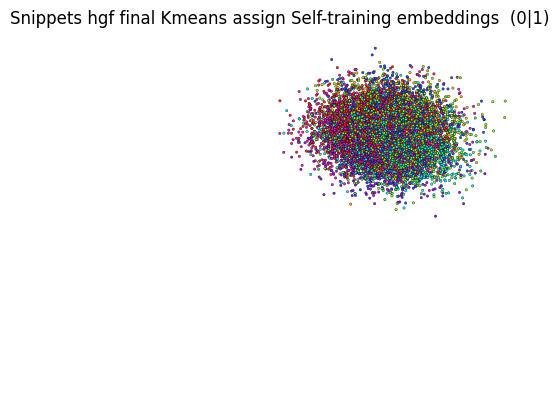

In [53]:
plot.commonSpace_plot(X_train, comp=[0, 1], tagLabels=y_km_o,
                      data_name="Snippets hgf final Kmeans assign", dimred = '')

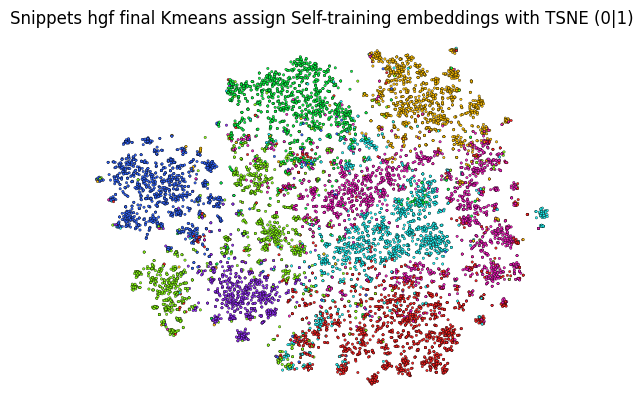

In [49]:
plot.commonSpace_plot(X_train, comp=[0, 1], tagLabels=y_km_o,
                      data_name="Snippets hgf final Kmeans assign", dimred = 'TSNE')

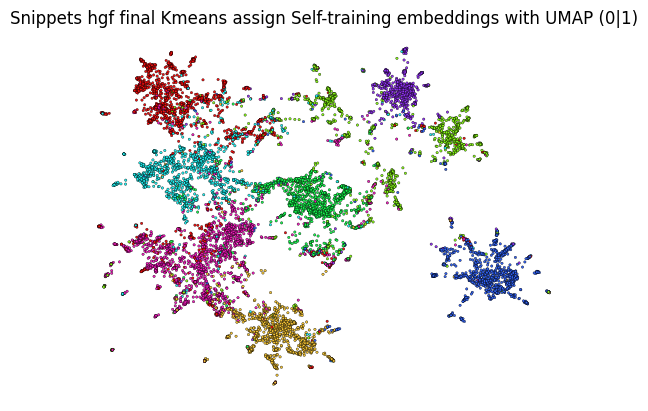

In [50]:
plot.commonSpace_plot(X_train, comp=[0, 1], tagLabels=y_km_o,
                      data_name="Snippets hgf final Kmeans assign", dimred = 'UMAP')

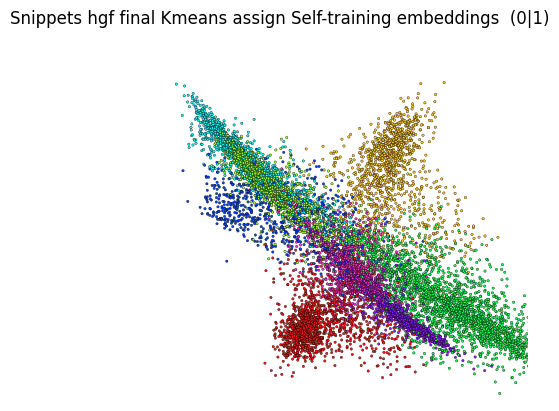

In [51]:
plot.commonSpace_plot(z2.detach().numpy(), comp=[0, 1], tagLabels=y_km_e,
                      data_name="Snippets hgf final Kmeans assign", dimred = '')

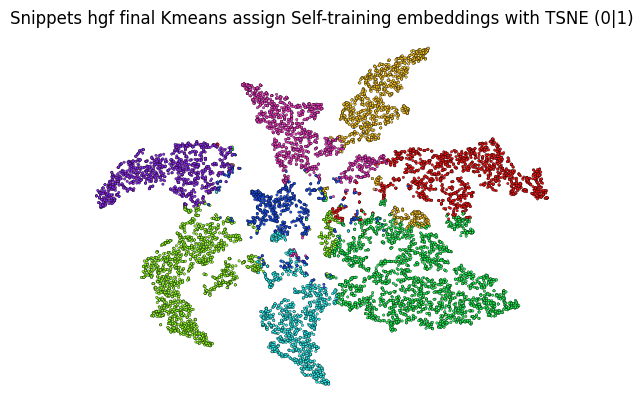

In [52]:
plot.commonSpace_plot(z2.detach().numpy(), comp=[0, 1], tagLabels=y_km_e,
                      data_name="Snippets hgf final Kmeans assign", dimred = 'TSNE')

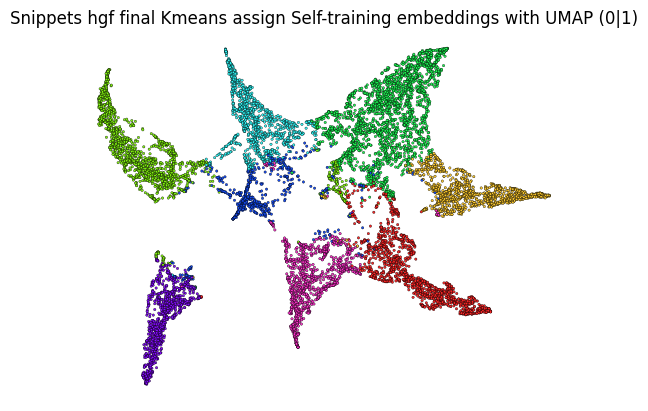

In [54]:
plot.commonSpace_plot(z2.detach().numpy(), comp=[0, 1], tagLabels=y_km_e,
                      data_name="Snippets hgf final Kmeans assign", dimred = 'UMAP')

# HuggingFace

In [8]:
checkpoint_dir=join(dataset_dir, 
                    "artefacts",
                    "STC-d384:500:2000:20-epoch30-datSearchSnippets-wdeHuggingFace-scaMinMax-tfeSIF-normNone-initSphericalKmeans"
                    )

checkpoint = "STC-datSearchSnippets-wdeHuggingFace-scaMinMax-tfeSIF-normNone-initSphericalKmeans.pth"
checkpoint_path = join(checkpoint_dir, checkpoint)
checkpoint_path

'/home/godwin/Documents/academic/PPD/torchSTC/demos/SearchSnippets/wdecay/../../../datasets/SearchSnippets/artefacts/STC-d384:500:2000:20-epoch30-datSearchSnippets-wdeHuggingFace-scaMinMax-tfeSIF-normNone-initSphericalKmeans/STC-datSearchSnippets-wdeHuggingFace-scaMinMax-tfeSIF-normNone-initSphericalKmeans.pth'

In [9]:
x, y = load_data(dataset=dataset_dir, word_emb='HuggingFace', transform='SIF', scaler='MinMax', norm=None)
n_clusters = len(torch.unique(torch.tensor(y)))

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)

# conversion des données en tenseurs
X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

stc = STC(hidden_dims=[torch.Tensor(X_train).shape[-1], 500, 2000, 20], n_clusters=n_clusters)
stc.from_pretrained(checkpoint_path)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

MinMax scaling completed...


(torch.Size([11106, 384]),
 torch.Size([1234, 384]),
 torch.Size([11106]),
 torch.Size([1234]))

In [10]:
z3 = stc.autoencoder.encoder(X_train)

In [11]:
# comprehension list with 5 runs of kmeans, get average and std of metrics
avg_w2v_mmx_ikm3 = []
tmp = []
for i in range(5):
    kmeans = KMeans(n_clusters=n_clusters, n_init=100)
    kmeans.fit(z3.detach().numpy())
    y_km_pred = kmeans.labels_
    tmp.append(eval.allMetrics(y_train.detach().numpy(), y_km_pred))

avg_w2v_mmx_ikm3 = np.array(tmp)
np.round(avg_w2v_mmx_ikm3.mean(axis=0), 3) * 100, avg_w2v_mmx_ikm3.std(axis=0)

(array([72.3, 57.8, 53.6]), array([0.00010198, 0.00013266, 0.00017205]))

In [12]:
# comprehension list with 5 runs of kmeans, get average and std of metrics
avg_w2v_mmx_iskm3 = []
tmp = []
for i in range(5):
    kmeans = SphericalKmeans(n_clusters, n_init=100)
    kmeans.fit(z3.detach().numpy())
    y_km_pred = kmeans.labels_
    tmp.append(eval.allMetrics(y_train.detach().numpy(), y_km_pred))

avg_w2v_mmx_iskm3 = np.array(tmp)
np.round(avg_w2v_mmx_iskm3.mean(axis=0), 3) * 100, avg_w2v_mmx_iskm3.std(axis=0)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iter

(array([72.2, 56.4, 52.9]), array([0.03573321, 0.01961281, 0.02602763]))

In [13]:
from scipy.sparse import csr_matrix

# comprehension list with 5 runs of kmeans, get average and std of metrics
avg_w2v_mmx_iskmp3 = []
tmp = []
for i in range(5):
    skmeanspp = SphericalKmeansPlus(n_clusters=n_clusters)
    x = csr_matrix(z3.detach().numpy())
    skmeanspp.fit(x)
    y_km_pred = skmeanspp.labels_
    tmp.append(eval.allMetrics(y_train.detach().numpy(), y_km_pred))

avg_w2v_mmx_iskmp3 = np.array(tmp)
np.round(avg_w2v_mmx_iskmp3.mean(axis=0), 3) * 100, avg_w2v_mmx_iskmp3.std(axis=0)

(array([73.9, 57.3, 53.9]), array([0.02846078, 0.01383011, 0.03418272]))

# HuggingFace - init kmeans 

In [14]:
checkpoint_dir=join(dataset_dir, 
                    "artefacts",
                    "STC-d384:500:2000:20-epoch30-datSearchSnippets-wdeHuggingFace-scaMinMax-tfeSIF-normNone-initKmeans"
                    )

checkpoint = "STC-datSearchSnippets-wdeHuggingFace-scaMinMax-tfeSIF-normNone-initKmeans.pth"
checkpoint_path = join(checkpoint_dir, checkpoint)
checkpoint_path

'/home/godwin/Documents/academic/PPD/torchSTC/demos/SearchSnippets/wdecay/../../../datasets/SearchSnippets/artefacts/STC-d384:500:2000:20-epoch30-datSearchSnippets-wdeHuggingFace-scaMinMax-tfeSIF-normNone-initKmeans/STC-datSearchSnippets-wdeHuggingFace-scaMinMax-tfeSIF-normNone-initKmeans.pth'

In [15]:
x, y = load_data(dataset=dataset_dir, word_emb='HuggingFace', transform='SIF', scaler='MinMax', norm=None)
n_clusters = len(torch.unique(torch.tensor(y)))

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)

# conversion des données en tenseurs
X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

stc = STC(hidden_dims=[torch.Tensor(X_train).shape[-1], 500, 2000, 20], n_clusters=n_clusters)
stc.from_pretrained(checkpoint_path)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

MinMax scaling completed...


(torch.Size([11106, 384]),
 torch.Size([1234, 384]),
 torch.Size([11106]),
 torch.Size([1234]))

In [16]:
z4 = stc.autoencoder.encoder(X_train)

In [17]:
# comprehension list with 5 runs of kmeans, get average and std of metrics
avg_w2v_mmx_ikm4 = []
tmp = []
for i in range(5):
    kmeans = KMeans(n_clusters=n_clusters, n_init=100)
    kmeans.fit(z4.detach().numpy())
    y_km_pred = kmeans.labels_
    tmp.append(eval.allMetrics(y_train.detach().numpy(), y_km_pred))

avg_w2v_mmx_ikm4 = np.array(tmp)
np.round(avg_w2v_mmx_ikm4.mean(axis=0), 3) * 100, avg_w2v_mmx_ikm4.std(axis=0)

(array([74.1, 59.4, 54.8]),
 array([0.00000000e+00, 4.89897949e-05, 4.89897949e-05]))

In [18]:
# comprehension list with 5 runs of kmeans, get average and std of metrics
avg_w2v_mmx_iskm4 = []
tmp = []
for i in range(5):
    kmeans = SphericalKmeans(n_clusters, n_init=100)
    kmeans.fit(z4.detach().numpy())
    y_km_pred = kmeans.labels_
    tmp.append(eval.allMetrics(y_train.detach().numpy(), y_km_pred))

avg_w2v_mmx_iskm4 = np.array(tmp)
np.round(avg_w2v_mmx_iskm4.mean(axis=0), 3) * 100, avg_w2v_mmx_iskm4.std(axis=0)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteratio

(array([74.9, 59.2, 55.6]), array([0.01456415, 0.00357961, 0.01514152]))

In [19]:
from scipy.sparse import csr_matrix

# comprehension list with 5 runs of kmeans, get average and std of metrics
avg_w2v_mmx_iskmp4 = []
tmp = []
for i in range(5):
    skmeanspp = SphericalKmeansPlus(n_clusters=n_clusters)
    x = csr_matrix(z4.detach().numpy())
    skmeanspp.fit(x)
    y_km_pred = skmeanspp.labels_
    tmp.append(eval.allMetrics(y_train.detach().numpy(), y_km_pred))

avg_w2v_mmx_iskmp4 = np.array(tmp)
np.round(avg_w2v_mmx_iskmp4.mean(axis=0), 3) * 100, avg_w2v_mmx_iskmp4.std(axis=0)

(array([74.4, 58.6, 55. ]), array([0.05827049, 0.01760416, 0.04799698]))

In [20]:
skmeans = KMeans(n_clusters=n_clusters, n_init=50)
skmeans.fit(z4.detach().numpy())
y_skm_pred4 = skmeans.labels_

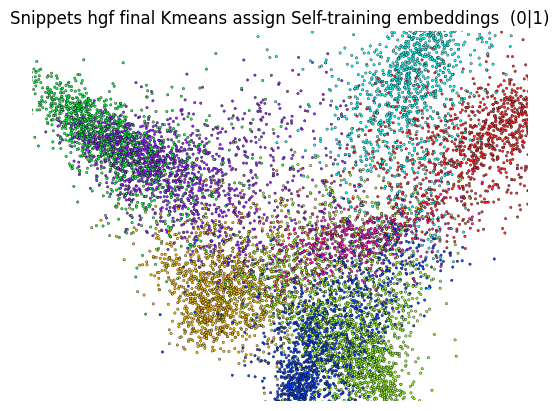

In [25]:
plot.commonSpace_plot(z4.detach().numpy(), comp=[0, 1], tagLabels=y_skm_pred4,
                      data_name="Snippets hgf final Kmeans assign", dimred = '')

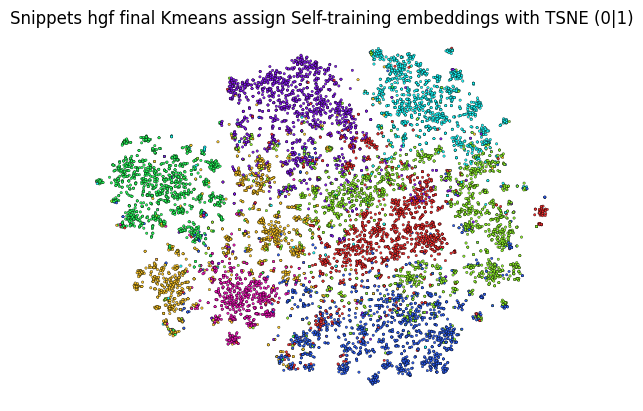

In [29]:
plot.commonSpace_plot(X_train, comp=[0, 1], tagLabels=y_skm_pred4,
                      data_name="Snippets hgf final Kmeans assign", dimred = 'TSNE')

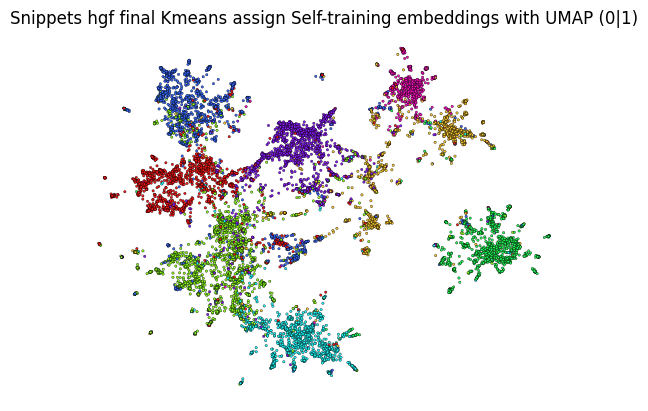

In [28]:
plot.commonSpace_plot(X_train, comp=[0, 1], tagLabels=y_skm_pred4,
                      data_name="Snippets hgf final Kmeans assign", dimred = 'UMAP')

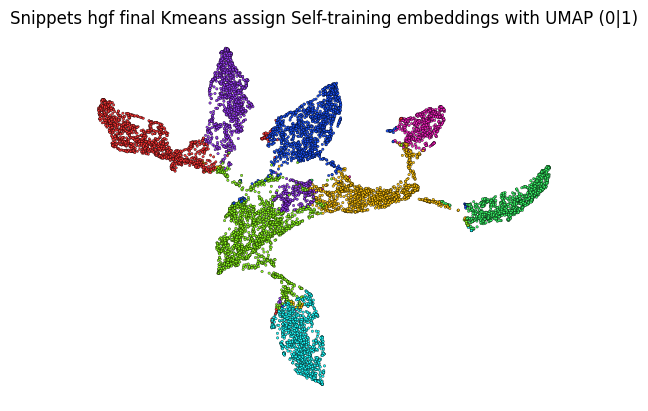

In [27]:
plot.commonSpace_plot(z4.detach().numpy(), comp=[0, 1], tagLabels=y_skm_pred4,
                      data_name="Snippets hgf final Kmeans assign", dimred = 'UMAP')

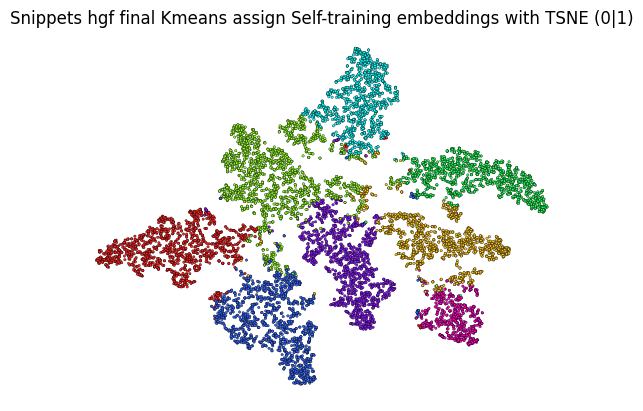

In [22]:
plot.commonSpace_plot(z4.detach().numpy(), comp=[0, 1], tagLabels=y_skm_pred4,
                      data_name="Snippets hgf final Kmeans assign", dimred = 'TSNE')

# Try litle crazy thing

In [30]:
import umap

In [38]:
z4.detach().numpy().shape

(11106, 20)

In [43]:
r4 = umap.UMAP(n_components = 15)
z4_umap = r4.fit_transform(z4.detach().numpy())

In [44]:
skmeans_z4_umap = KMeans(n_clusters=n_clusters, n_init=50)
skmeans_z4_umap.fit(z4_umap)
y_skm_pred_z4_umap = skmeans_z4_umap.labels_

In [45]:
eval.allMetrics(y_train.detach().numpy(), y_skm_pred_z4_umap)

[0.7356, 0.6001, 0.552]